In [ ]:
%pip install rank-bm25

In [2]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.document_loaders.merge import MergedDataLoader

from rank_bm25 import BM25Okapi
from collections import defaultdict

from langchain.docstore.document import Document
from langchain_community.vectorstores import FAISS

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [9]:
# Load evaluation data
eval_data = pd.read_csv('../../data/questions_answers/questions_answers.csv')
eval_data.rename(columns={eval_data.columns[0]: 'PMID'}, inplace=True)

gold_pmids = eval_data['PMID'].to_list()
eval_queries = eval_data['QUESTION'].to_list()

# Load abstracts data
df1 = pd.read_csv('../../data/processed_data_part1.csv', usecols=['PMID', 'Abstract'])
df2 = pd.read_csv('../../data/processed_data_part2.csv', usecols=['PMID', 'Abstract'])

# Merge the datasets
abstracts = pd.concat([df1, df2], ignore_index=True)

In [12]:
# Create corpus for BM25
corpus = abstracts['Abstract'].tolist()
tokenized_corpus = [doc.split(" ") for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

print(tokenized_corpus[:10])
print(len(tokenized_corpus))

[['SUMMARY', 'Several', 'lines', 'of', 'evidence', 'support', 'the', 'involvement', 'of', 'inflammatory', 'and', 'immunologic', 'abnormalities', 'in', 'chronic', 'fatigue', 'syndrome', 'CFS', 'Since', 'recent', 'studies', 'have', 'shown', 'that', 'α1', 'antitrypsin', 'AAT', 'possesses', 'antiinflammatory', 'properties', 'the', 'potential', 'therapeutic', 'effect', 'of', 'AAT', 'treatment', 'on', 'CFS', 'has', 'been', 'investigated', 'A', '49yearold', 'woman', 'diagnosed', 'with', 'CFS', 'was', 'treated', 'with', 'intravenous', 'infusions', 'of', 'a', 'human', 'plasmaderived', 'AAT', 'concentrate', '60', 'mgkg', 'body', 'weight', 'weekly', 'for', '8', 'consecutive', 'weeks', 'The', 'patients', 'monocyte', 'elastase', 'a', 'regulator', 'of', 'inflammatory', 'processes', 'was', '1170', 'Umg', 'At', 'completion', 'of', 'treatment', 'improvement', 'in', 'maximal', 'workload', 'was', 'observed', '540717', 'of', 'predicted', 'Additionally', 'amelioration', 'in', 'working', 'memory', 'scores',

In [23]:
accuracies = []

# Evaluate BM25 for different values of k
for k in range(1, 21):
    matches = 0
    for query, gold_label in zip(eval_queries, gold_pmids):
        tokenized_query = query.split(" ")
        doc_scores = bm25.get_scores(tokenized_query)
        
        # Get indices of top k documents
        top_k_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)[:k]
        
        # Convert indices to PMIDs
        retrieved_pmids = [int(abstracts['PMID'].iloc[i]) for i in top_k_indices]
        
        
        if gold_label in retrieved_pmids:
            matches += 1

    accuracy = matches / len(eval_queries)
    accuracies.append(accuracy)

# Save accuracies to a text file
file_path = './text_files/keyword_search_bm25_accuracies.txt'
with open(file_path, 'w') as f:
    for accuracy in accuracies:
        f.write(f"{accuracy}\n")

# Plotting the results
plot_title = "Keyword Search Accuracy with BM25"
file_name = './images/keyword_search_bm25_accuracies.png'

plt.plot(range(1, 21), accuracies, marker='o')
plt.xlabel('k (Number of Top Results Considered)')
plt.ylabel('Accuracy')
plt.title(plot_title)
plt.xticks(range(1, 21))

plt.savefig(file_name)


Schizophrenia patients with high intelligence: A clinically distinct sub-type of schizophrenia? - gold: 25752725 - [29734953]
Do audiologic characteristics predict outcomes in children with unilateral hearing loss? - gold: 24232067 - [24232067]
Schizophrenia patients with high intelligence: A clinically distinct sub-type of schizophrenia? - gold: 25752725 - [29734953, 29730869]
Do audiologic characteristics predict outcomes in children with unilateral hearing loss? - gold: 24232067 - [24232067, 26452077]
[0.005988023952095809, 0.005988023952095809]


ValueError: x and y must have same first dimension, but have shapes (20,) and (2,)

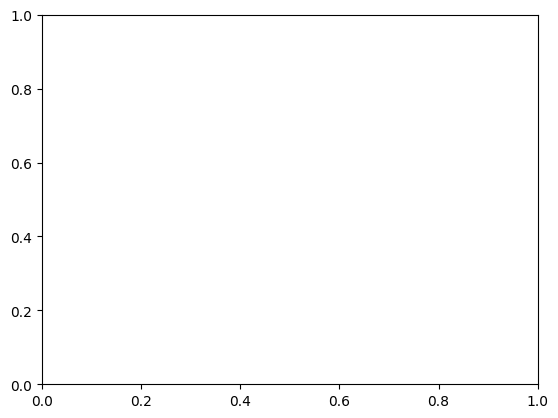

In [21]:
accuracies = []

# Evaluate BM25 for different values of k
for k in range(1, 3):
    matches = 0
    for query, gold_label in zip(eval_queries[:2], gold_pmids[:2]):
        tokenized_query = query.split(" ")
        doc_scores = bm25.get_scores(tokenized_query)
        
        # Get indices of top k documents
        top_k_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)[:k]
  
        # Convert indices to PMIDs
        retrieved_pmids = [int(abstracts['PMID'].iloc[i]) for i in top_k_indices]
        print(f"{query} - gold: {gold_label} - {retrieved_pmids}")
        
        if gold_label in retrieved_pmids:
            matches += 1

    accuracy = matches / len(eval_queries)
    accuracies.append(accuracy)


print(accuracies)

# Plotting the results
plot_title = "Keyword Search Accuracy with BM25"
file_name = './images/keyword_search_bm25_accuracies.png'

plt.plot(range(1, 21), accuracies, marker='o')
plt.xlabel('k (Number of Top Results Considered)')
plt.ylabel('Accuracy')
plt.title(plot_title)
plt.xticks(range(1, 21))

